In [ ]:
import os
print(os.getcwd())
os.chdir('experimentation_files')

/mnt/c/Users/User/MSc_Project/energy_budget_PET_framework-1


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import sys
import io
import warnings
data_original = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')

data = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')
data = data.drop('dataset_name', axis=1)


In [3]:
features = [
    'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
 ]

features_temp = [
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
]

print(len(features_temp))


target_acc_knn = 'accuracy_knn'

20


In [ ]:
import heapq
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import pandas as pd
import random
def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]

            # Appending 0 if first is greater, otherwise 1
            if first > second:
                result.append(0)
            elif first == second:
                result.append(2)
            else:
                result.append(1)
    return result
def bfs_feature_selection(data, features, target, test_size,  models = 0, n_estimators=50, learning_rate=0.1, depth=-1, max_depth_tree=10, max_features='sqrt', max_samples=0.8
                          , includee=[]):
    best_mse = float('inf')
    best_r2 = -1
    best_features = None
    best_model = None
    visited = set()
    evaluation_count = 0

    # Priority queue for Best-First Search
    priority_queue = []

    if len(includee) == 0:
         initial_features = ['epsilon']
    else:
         initial_features = ['epsilon'] + includee
    heapq.heappush(priority_queue, (float('-inf'), initial_features))
    if models ==0:
        print('LightGBM Regressor')
    elif models ==1:
        print('HitsGB Regressor')
    else:
        print('Regular GB Regressor')

    print("Starting BFS feature selection...")

    while priority_queue:
        current_r2, current_features = heapq.heappop(priority_queue)

        current_features_tuple = tuple(sorted(current_features))
        if current_features_tuple in visited:
            continue

        visited.add(current_features_tuple)

        # Prepare the data with the current feature set
        X = data[current_features]
        y = data[target]

        if X.empty or y.empty:
            print(f"Skipping empty data slice for features: {current_features}")
            continue
        # We are using here first 19% for test
        split_index = int(test_size * len(data)) 
        if split_index % 2 != 0:
            split_index += 1
        X_train, X_test = X.iloc[split_index:], X.iloc[:split_index]
        y_train, y_test = y.iloc[split_index:], y.iloc[:split_index]

        if X_train.empty or y_train.empty:
            print(f"Skipping empty training data for features: {current_features}")
            continue

        if models == 0:
            model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1, max_depth = depth,   n_jobs=2)
    
        else:
            if depth <= 0:
                depth = 3
            model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=depth, random_state=42
                                         # ,  n_jobs=2
                                             )
        try:
            model.fit(X_train, y_train)
        except ValueError as e:
            print(f"Error fitting model with features: {current_features}, Error: {e}")
            continue

        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Ensure that both y_pred and y_test are even length
        if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
            aa = []
            y_test_2 = y_test.reset_index(drop=True)
            y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
            res_act = comp_func(y_test_2)  
            res_pred = comp_func(y_pred_2)
            for i in range(len(res_act)):
                aa.append(res_act[i] == res_pred[i])

            acc = (aa.count(True) / len(aa)) * 100
        else:
            acc = 0

        evaluation_count += 1

        # Update the best result if r2 improves
        if r2 > best_r2:
            best_r2 = r2
            best_mse = mse
            best_features = current_features
            best_acc = acc
            best_model = model
            print(f"\nNew best R²: {best_r2:.10f}, MSE: {best_mse:.10f}, Compare Accuracy: {best_acc:.2f}% with features: {best_features}")

        if evaluation_count % 200 == 0:
            print(f"\rEvaluated {evaluation_count} combinations so far...", end='', flush=True)

        # Generate new combinations by adding one more feature to the current set
        # om = features.copy()
        # random.shuffle(om)
        # for feature in om:
        for feature in features:
            if feature not in current_features:
                new_features = current_features + [feature]
                # Push -r2 to prioritize higher R² values
                heapq.heappush(priority_queue, (-r2, new_features))

    print("\nBFS complete.")
    print(f"Best feature combination: {best_features}")
    print(f"Best R²: {best_r2:.10f}")
    print(f"Best MSE: {best_mse:.10f}")

    return best_model, best_features, best_mse, best_r2


In [14]:
bfs_feature_selection(data, features_temp, target_acc_knn, 0.19,
                      models = 0, learning_rate = 0.1, n_estimators=100, 
                      max_features='sqrt', max_samples=0.8
                      # , includee = ['k-values']
                     )
"""
60 minutes
New best R²: 0.4032841022, MSE: 0.0246962512, Compare Accuracy: 86.21% with features: ['epsilon', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'max_categorical_unique', 'max_continuous_correlation', 'mean_continuous_correlation', 'outlier_percentage', 'num_categorical_attributes', 'size_mb']

"""

LightGBM Regressor
Starting BFS feature selection...

New best R²: 0.0564467093, MSE: 0.0390507931, Compare Accuracy: 79.31% with features: ['epsilon']

New best R²: 0.0741961797, MSE: 0.0383161967, Compare Accuracy: 79.31% with features: ['epsilon', 'avg_cat_uniqueness_ratio']

New best R²: 0.1283814016, MSE: 0.0360736356, Compare Accuracy: 68.97% with features: ['epsilon', 'avg_cat_uniqueness_ratio', 'entropy']

New best R²: 0.1627683278, MSE: 0.0346504656, Compare Accuracy: 68.97% with features: ['epsilon', 'avg_cat_uniqueness_ratio', 'entropy', 'max_continuous_correlation']

New best R²: 0.1890052021, MSE: 0.0335646014, Compare Accuracy: 82.76% with features: ['epsilon', 'avg_cat_uniqueness_ratio', 'entropy', 'max_continuous_correlation', 'kurtosis']

New best R²: 0.1919595630, MSE: 0.0334423294, Compare Accuracy: 79.31% with features: ['epsilon', 'avg_cat_uniqueness_ratio', 'entropy', 'max_continuous_correlation', 'kurtosis', 'mean_continuous_correlation']

New best R²: 0.20464316

KeyboardInterrupt: 

# 

In [ ]:
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]

            # Appending 0 if first is greater, otherwise 1
            if first > second:
                result.append(0)
            elif first == second:
                result.append(2)
            else:
                result.append(1)
    return result

def our_ml(dataset, test_size, our_features, estimators, learning_rate, depth, target, scalee):
    
    split_index = int(test_size * len(dataset))
    X = dataset[list(our_features)]
    y = dataset[target]
    if scalee == 1:
            continuous_ones = [i for i in our_features if i != 'epsilon']

            X_scaled = X.copy()
            X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])

            # X_train = X.iloc[:split_index]
            # X_test = X.iloc[split_index:]  
            X_train = X_scaled.iloc[:split_index]
            X_test = X_scaled.iloc[split_index:]
            
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    print(len(y_test))
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    
    gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)
    print('Conditions:')
    print(f'Size: {len(dataset)}')
    print(f'Test size percent is: {test_size}')
    print(f'Attributes: {our_features}')
    print('Actual')
    print(list(y_test))
    print('Prediction')
    print(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Gradient Boosting MSE:", mse)
    print("Gradient Boosting R²:", r2)

    feature_importances = gb_model.feature_importances_

    importances = pd.Series(feature_importances, index=our_features)
    
    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        
        print(aa)
        
        num = aa.count(True)
        length = len(aa)
        print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {(num / length) * 100} %')
        y_test_2 = list(y_test)
     
    else:
        print('Fix the test size for even number of values.')
        y_pred = 0
        y_test_2 = 0


  
    return gb_model, y_pred, y_test_2, importances


def lightgbm_ml(our_data, our_features, target, perc, scalee, n_estimators=100, learning_rate=0.1):
    warnings.simplefilter(action='ignore', category=UserWarning)
    test_size = perc
    split_index = int(test_size * len(our_data))
    if split_index % 2 != 0:
        split_index += 1
    X = our_data[list(our_features)]
    y = our_data[target]

    if scalee == 1:
        continuous_ones = [i for i in our_features if i != 'epsilon']
        X_scaled = X.copy()
        X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])
        X_train = X_scaled.iloc[split_index:]
        X_test = X_scaled.iloc[:split_index]
    else:
        X_train = X.iloc[split_index:]
        X_test = X.iloc[:split_index]

    y_train = y.iloc[split_index:]
    y_test = y.iloc[:split_index]
    print(len(y_test))

    model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)  
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
        aa = []
        y_test_2 = y_test.reset_index(drop=True)
        y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
        res_act = comp_func(y_test_2)
        res_pred = comp_func(y_pred_2)
        
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
    else:
        aa = []
        acc = 0

    print('\n')
    print(f'Conditions for {target}:')
    print("LightGBM Regression")
    if scalee == 1:
        print("With Scaler")
    print(f'Number of Estimators: {n_estimators}')
    print(f'Learning Rate: {learning_rate}')
    print(f"Best MSE: {mse:.10f}")
    print(f"Best R²: {r2:.10f}")
    print(f'Test size: {perc}')
    print(f"Best Feature Combination: {our_features}")
    print(f'Accuracy: {acc}%')
    
    print("Feature Importances:")
    single_importances_series = pd.Series(model.feature_importances_ , index=our_features)
    importances_percentages = (single_importances_series / single_importances_series.sum())
    print(importances_percentages)
    
        
    
    return model, y_pred.tolist(), y_test.tolist(), importances_percentages, mse, r2, acc




58


Conditions for accuracy_knn:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0246962512
Best R²: 0.4032841022
Test size: 0.19
Best Feature Combination: ['epsilon', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'max_categorical_unique', 'max_continuous_correlation', 'mean_continuous_correlation', 'outlier_percentage', 'num_categorical_attributes', 'size_mb']
Accuracy: 86.20689655172413%
Feature Importances:
epsilon                        0.133017
avg_cat_uniqueness_ratio       0.119952
imbalance_ratio                0.127078
max_categorical_unique         0.091449
max_continuous_correlation     0.102138
mean_continuous_correlation    0.115202
outlier_percentage             0.134204
num_categorical_attributes     0.054632
size_mb                        0.122328
dtype: float64


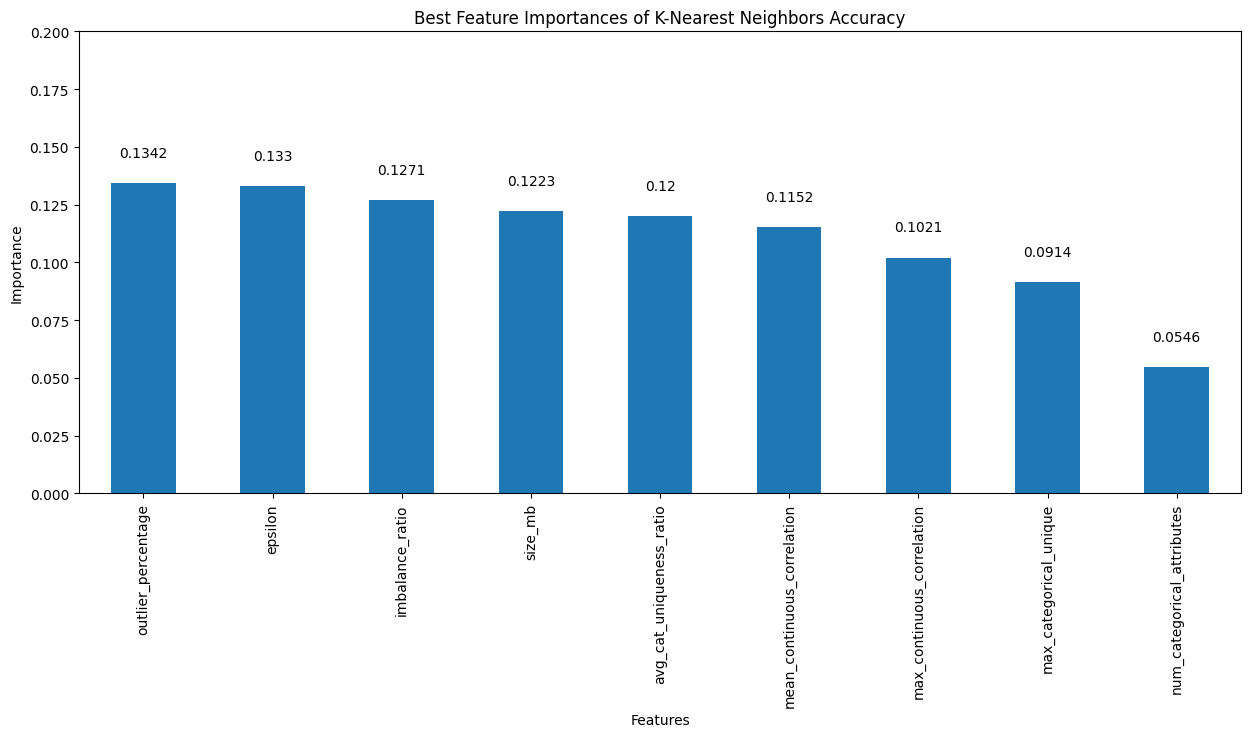

"\nBest MSE: 0.0246962512\nBest R²: 0.4032841022\nTest size: 0.19\nBest Feature Combination: ['epsilon', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'max_categorical_unique', 'max_continuous_correlation', 'mean_continuous_correlation', 'outlier_percentage', 'num_categorical_attributes', 'size_mb']\nAccuracy: 86.20689655172413%\n"

In [ ]:

best_features =  ['epsilon', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'max_categorical_unique', 'max_continuous_correlation', 
              'mean_continuous_correlation', 'outlier_percentage', 'num_categorical_attributes', 'size_mb']

knn_acc_model, knn_acc_pred, knn_acc_actual, knn_acc_importances, knn_mse, knn_r2, knn_acc=  lightgbm_ml(data, best_features,  target_acc_knn, 0.19, 0,  100, 0.1)

first_importances_sorted = knn_acc_importances.sort_values(ascending=False)
plt.figure(figsize=(15, 6))
plt.ylim(0, 0.2)
ax = first_importances_sorted.plot(kind='bar')
for i, v in enumerate(first_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
plt.title('Best Feature Importances of K-Nearest Neighbors Accuracy')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()

"""
Best MSE: 0.0246962512
Best R²: 0.4032841022
Test size: 0.19
Best Feature Combination: ['epsilon', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'max_categorical_unique', 'max_continuous_correlation', 'mean_continuous_correlation', 'outlier_percentage', 'num_categorical_attributes', 'size_mb']
Accuracy: 86.20689655172413%
"""

['epsilon', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'max_categorical_unique', 'max_continuous_correlation', 'mean_continuous_correlation', 'outlier_percentage', 'num_categorical_attributes', 'size_mb']

Importances Sorted
['outlier_percentage', 'epsilon', 'imbalance_ratio', 'size_mb', 'avg_cat_uniqueness_ratio', 'mean_continuous_correlation', 'max_continuous_correlation', 'max_categorical_unique', 'num_categorical_attributes']
58


Conditions for accuracy_knn:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0262395500
Best R²: 0.3659945985
Test size: 0.19
Best Feature Combination: ['outlier_percentage', 'epsilon', 'imbalance_ratio', 'size_mb', 'avg_cat_uniqueness_ratio', 'mean_continuous_correlation', 'max_continuous_correlation', 'max_categorical_unique', 'num_categorical_attributes']
Accuracy: 82.75862068965517%
Feature Importances:
outlier_percentage             0.143705
epsilon                        0.133017
imbalance_ratio                0.1175

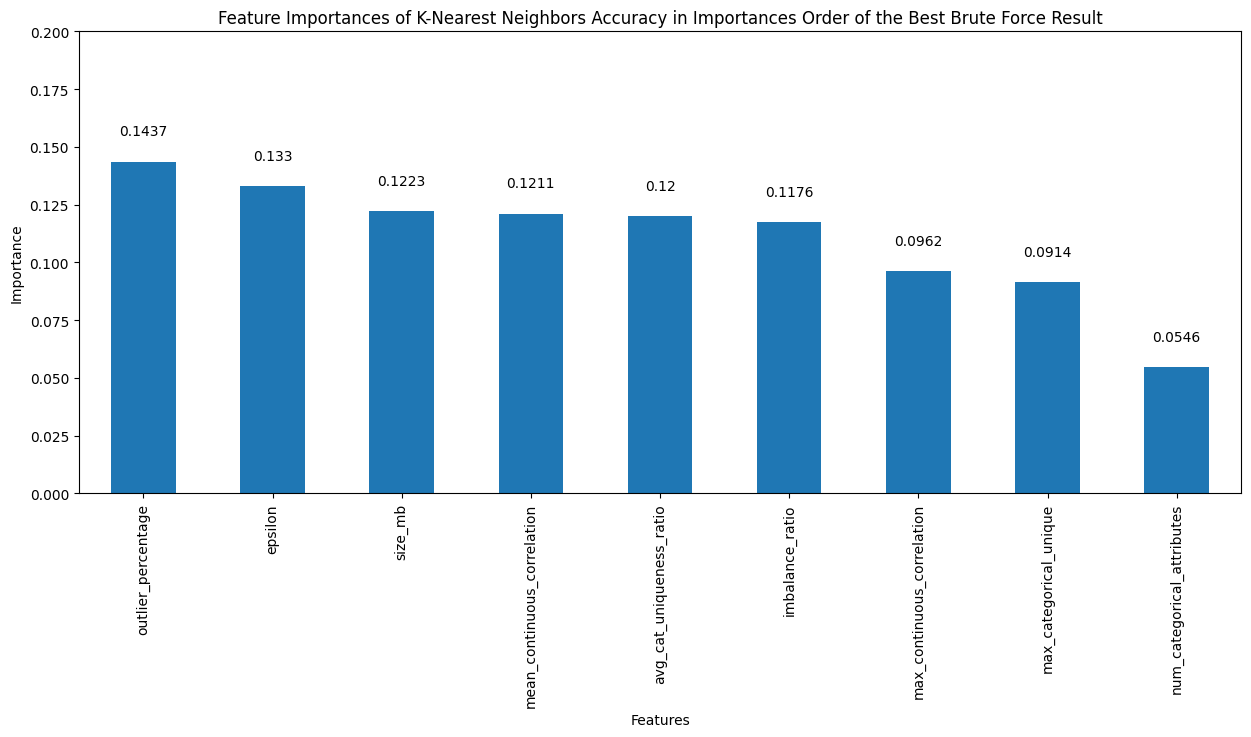

In [ ]:
fffff = first_importances_sorted.index.tolist()
print(best_features)
print('\nImportances Sorted')
print(fffff)

ee0, ee1, ee2, ee3_importances, ee4, ee5, ee6  = lightgbm_ml(data, fffff, target_acc_knn, 0.19, 0, 100, 0.1)
ee3_importances_sorted = ee3_importances.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
ax = ee3_importances_sorted.plot(kind='bar')
for i, v in enumerate(ee3_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
plt.ylim(0, 0.2)
plt.title('Feature Importances of K-Nearest Neighbors Accuracy in Importances Order of the Best Brute Force Result')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()

"""  
Best MSE: 0.0246962512
Best R²: 0.4032841022
Test size: 0.19
Best Feature Combination: ['epsilon', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'max_categorical_unique', 'max_continuous_correlation', 'mean_continuous_correlation', 'outlier_percentage', 'num_categorical_attributes', 'size_mb']
Accuracy: 86.20689655172413%

Best MSE: 0.0262395500
Best R²: 0.3659945985
Test size: 0.19
Best Feature Combination: ['outlier_percentage', 'epsilon', 'imbalance_ratio', 'size_mb', 'avg_cat_uniqueness_ratio', 'mean_continuous_correlation', 'max_continuous_correlation', 'max_categorical_unique', 'num_categorical_attributes']
Accuracy: 82.75862068965517%

"""

In [ ]:
datasets = data_original['dataset_name']
print(datasets[:58])

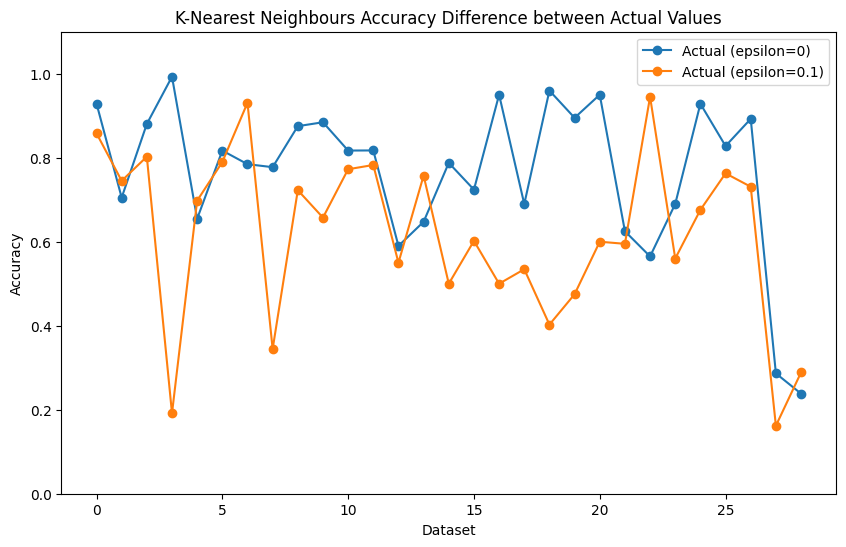

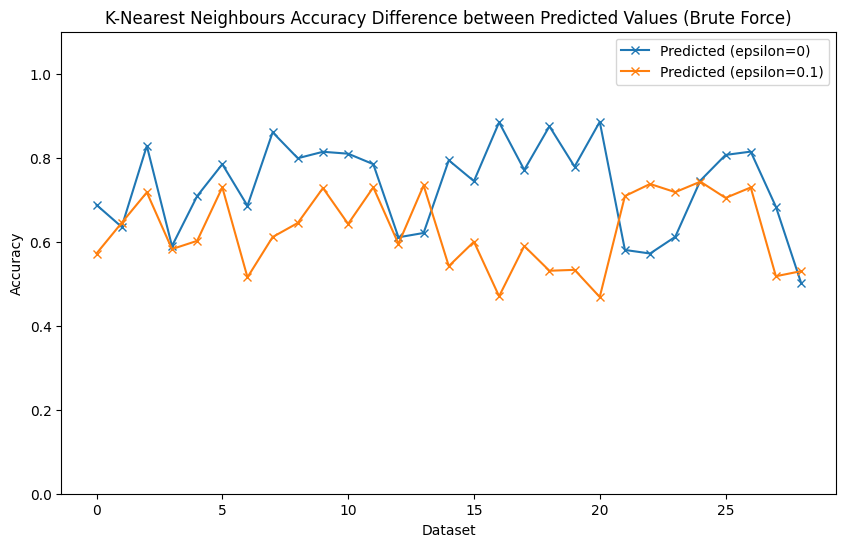

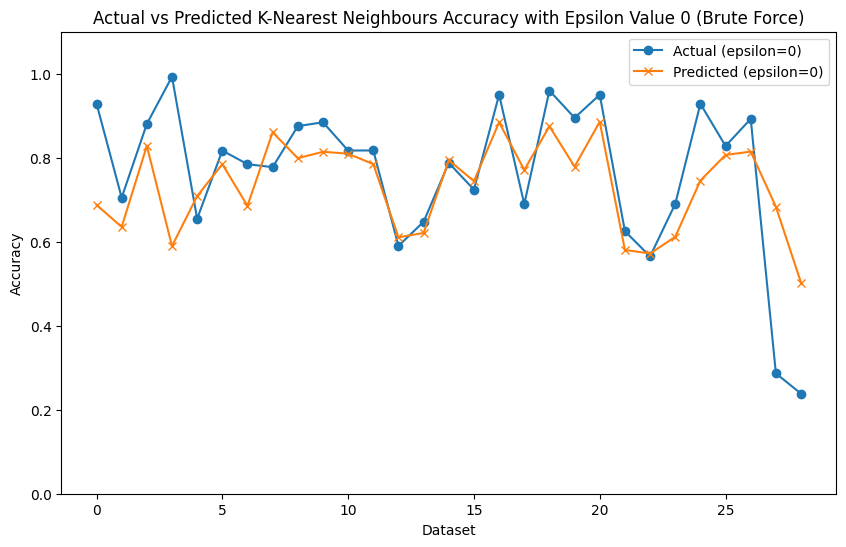

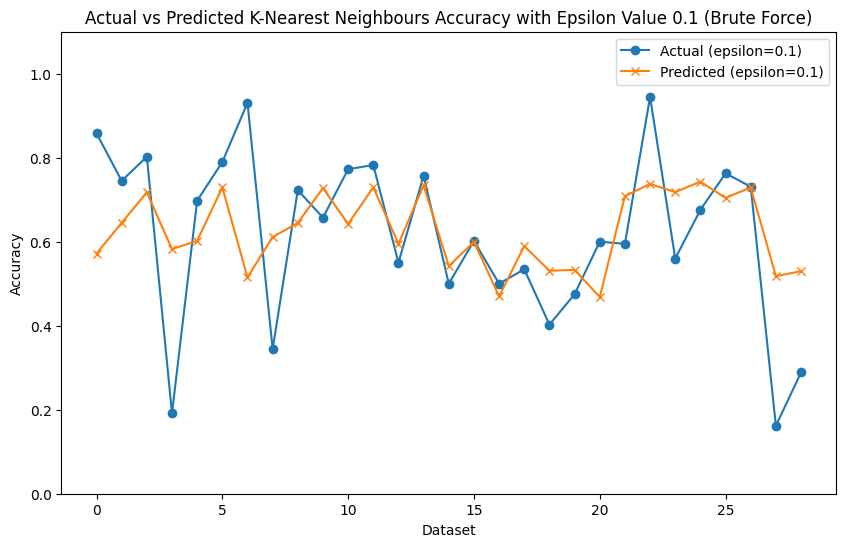

In [ ]:
import matplotlib.pyplot as plt

knn_acc_actual_0 = [knn_acc_actual[i] for i in range(0, len(knn_acc_actual), 2)]   # Actual values for epsilon 0
knn_acc_actual_01 = [knn_acc_actual[i] for i in range(1, len(knn_acc_actual), 2)]  # Actual values for epsilon 0.1
y_pred_0 = [knn_acc_pred[i] for i in range(0, len(knn_acc_pred), 2)]  # Predicted values for epsilon 0
y_pred_01 = [knn_acc_pred[i] for i in range(1, len(knn_acc_pred), 2)] # Predicted values for epsilon 0.1

x_indices_0 = range(len(knn_acc_actual_0))     # Indices for epsilon 0
x_indices_01 = range(len(knn_acc_actual_01))   # Indices for epsilon 0.1

# y_min = min(min(knn_acc_actual_0), min(knn_acc_actual_01), min(y_pred_0), min(y_pred_01)) - 0.05 
# y_max = max(max(knn_acc_actual_0), max(knn_acc_actual_01), max(y_pred_0), max(y_pred_01)) + 0.05
y_min = 0
y_max = 1.1

# Plot 1: Difference between actual values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, knn_acc_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_01, knn_acc_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.ylim(y_min, y_max)   
plt.title('K-Nearest Neighbours Accuracy Difference between Actual Values')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('knn_accuracy_difference_between_actual_values.png')  
plt.show()

# Plot 2: Difference between predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)  
plt.title('K-Nearest Neighbours Accuracy Difference between Predicted Values (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('knn_brute_accuracy_difference_between_predicted_values.png')  

# Plot 3: Actual vs Predicted for epsilon 0
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, knn_acc_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.ylim(y_min, y_max)  
plt.title('Actual vs Predicted K-Nearest Neighbours Accuracy with Epsilon Value 0 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('knn_brute_accuracy_actual_vs_predicted_epsilon_0.png')  
plt.show()

# Plot 4: Actual vs Predicted for epsilon 0.1
plt.figure(figsize=(10, 6))
plt.plot(x_indices_01, knn_acc_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)  
plt.title('Actual vs Predicted K-Nearest Neighbours Accuracy with Epsilon Value 0.1 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('knn_brute_accuracy_actual_vs_predicted_epsilon_01.png')  
plt.show()


In [ ]:

sns.histplot(data[target_acc_knn], kde=True)
plt.title('Distribution of k-Nearest Neighbours Accuracy')
plt.savefig('knn_accuracy_distribution.png') 
plt.show()